In [1]:
import sys
from pathlib import Path
project_root = Path('./').resolve().parent
sys.path.append(str(project_root))

In [2]:
from utils.utils import load_yaml_config, concordance_index
from models.ensembles import Ensembles
import numpy as np
from matminer.featurizers.composition import ElementProperty
import pandas as pd

In [3]:
path_config = Path('./').resolve().parent / 'configs' / 'ensembles.yaml'
config = load_yaml_config(path_config)

In [4]:
config['data']['root_dir']=Path('./').resolve().parent / config['data']['root_dir']

In [5]:
config['features']['checkpoint_path']=Path('./').resolve().parent / config['features']['checkpoint_path']

In [6]:
model = Ensembles(**config)
model.prep_data()

RandomForestRegressor(random_state=11)


/opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/pymatgen/io/cif.py:1324: UserWarning: Issues encountered while parsing CIF: 16 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/pymatgen/io/cif.py:1324: UserWarning: Issues encountered while parsing CIF: 4 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/pymatgen/io/cif.py:1324: UserWarning: Issues encountered while parsing CIF: 8 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/pymatgen/io/cif.py:1

** Features are being calculated **


/opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(


/opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: dlopen(/opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/libpyg.so, 0x0006): Library not loaded: /Library/Frameworks/Python.framework/Versions/3.11/Python
  Referenced from: <CA14ED34-FA3D-31FE-B4AD-2B2A8446B324> /opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/libpyg.so
  Reason: tried: '/Library/Frameworks/Python.framework/Versions/3.11/Python' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/Python.framework/Versions/3.11/Python' (no such file), '/Library/Frameworks/Python.framework/Versions/3.11/Python' (no such file)
  import torch_geometric.typing
/opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen(/opt/miniconda3/envs/kpoint

test_ratio 1.0, train_ratio 0.0
calibration False, cal_ratio 0.0


In [7]:
from sklearn.model_selection import train_test_split

In [8]:
model.random_seed=11111

In [9]:
train_ind, test_ind = train_test_split(model.data.index.values, 
                                               test_size=model.test_ratio, 
                                               random_state=model.random_seed)
train_ind, cal_ind = train_test_split(train_ind, 
                                               test_size=model.test_ratio, 
                                               random_state=model.random_seed)
ytrain = np.array(model.data.iloc[train_ind][1].values,dtype='float')
ytest = np.array(model.data.iloc[test_ind][1].values,dtype='float')
ycal = np.array(model.data.iloc[cal_ind][1].values,dtype='float')
Xtrain = model.features[train_ind,:]
Xtest = model.features[test_ind,:]
Xcal = model.features[cal_ind,:]

In [10]:
from sklearn.ensemble import RandomForestRegressor

In [11]:
model1=RandomForestRegressor()
model1.fit(Xtrain,ytrain)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [12]:
ypred = model1.predict(Xtest)

In [13]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from scipy.stats import spearmanr, kendalltau

mse = mean_squared_error(ytest, ypred)
mae = mean_absolute_error(ytest, ypred)
mape = mean_absolute_percentage_error(ytest, ypred)
r2 = r2_score(ytest, ypred)
spearman_corr, _ = spearmanr(ytest, ypred)
kendall_corr, _ = kendalltau(ytest, ypred)
    # c_index = concordance_index(y_test, y_pred[strategy])

print(f'Test set MAE: {mae}')
print(f'Test set MAPE: {mape}')
print(f'Test set MSE: {mse}')
print(f'Test set R2 score: {r2}')
print(f'Test set spearman_corr: {spearman_corr}')
print(f'Test set kendall_corr: {kendall_corr}')

Test set MAE: 0.06793327827111764
Test set MAPE: 0.21262345359034984
Test set MSE: 0.009042069273344801
Test set R2 score: 0.6907008953975942
Test set spearman_corr: 0.8484427216879866
Test set kendall_corr: 0.6615566495491985


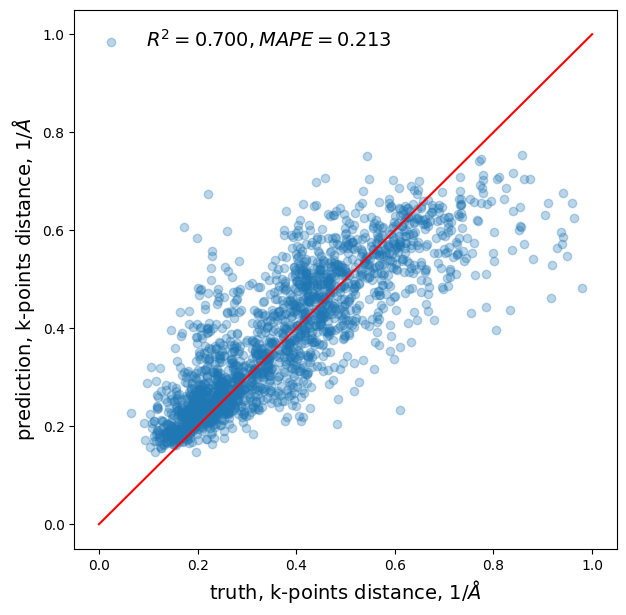

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.scatter(ytest,ypred, alpha=0.3,label='$R^2=0.700, MAPE=0.213$')
plt.plot([0,1],[0,1], color='red')
plt.xlabel('truth, k-points distance, $1/\AA$',fontsize=14)
plt.ylabel('prediction, k-points distance, $1/\AA$',fontsize=14)
plt.legend(fontsize=14,frameon=False)
plt.savefig("../figures/RF_best.png", dpi=300)
plt.show()

## Define features size

In [19]:
from utils.compound_features_utils import matminer_composition_features, matminer_structure_features
from utils.compound_features_utils import soap_features, jarvis_features, lattice_features, cgcnn_features 

### composition features

In [23]:
list_of_feat = [k for k, v in model.composition_features.items() if v]
composition_features = matminer_composition_features(model.data[:10], list_of_feat)
composition_features.shape

(10, 146)

### structure features

In [26]:
list_of_feat = [k for k, v in model.structure_features.items() if v]
structure_features = matminer_structure_features(model.data[:10], list_of_feat)
structure_features.shape

(10, 6)

### soap_features

In [28]:
soap_f = soap_features(model.data[:10],model.soap_params)
soap_f.shape

(10, 252)

### lattice_features

In [30]:
lattice_f = lattice_features(model.data[:10])
lattice_f.shape

(10, 15)

### metal_features

In [31]:
cgcnn_f = cgcnn_features(model.checkpoint_path, model.path, model.lmdb_exist)
cgcnn_f.shape

/Users/elena.patyukova/Documents/github/clean-kpoints/goldilocks_kpoints/utils/compound_features_utils.py:205: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = tor

test_ratio 1.0, train_ratio 0.0
calibration False, cal_ratio 0.0


(20178, 64)

# Shuffling composition

In [32]:
Xtest_composition=Xtest.copy()

In [33]:
for i in range(Xtest.shape[0]):
    feat_old=Xtest_composition[i,:composition_features.shape[1]]
    feat_new=np.random.shuffle(feat_old)
    Xtest_composition[i,:composition_features.shape[1]]=feat_new

In [34]:
ypred_comp = model1.predict(Xtest_composition)

In [35]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from scipy.stats import spearmanr, kendalltau

mse = mean_squared_error(ytest, ypred_comp )
mae = mean_absolute_error(ytest, ypred_comp )
mape = mean_absolute_percentage_error(ytest, ypred_comp )
r2 = r2_score(ytest, ypred_comp )
spearman_corr, _ = spearmanr(ytest, ypred_comp )
kendall_corr, _ = kendalltau(ytest, ypred_comp )
    # c_index = concordance_index(y_test, y_pred[strategy])

print(f'Test set MAE: {mae}')
print(f'Test set MAPE: {mape}')
print(f'Test set MSE: {mse}')
print(f'Test set R2 score: {r2}')
print(f'Test set spearman_corr: {spearman_corr}')
print(f'Test set kendall_corr: {kendall_corr}')

Test set MAE: 0.10185630424555346
Test set MAPE: 0.3662322727908307
Test set MSE: 0.01653411084825595
Test set R2 score: 0.43442308102659033
Test set spearman_corr: 0.7196179606495875
Test set kendall_corr: 0.515311022299954


# Shuffle structural features

In [36]:
Xtest_structure=Xtest.copy()

In [37]:
for i in range(Xtest.shape[0]):
    feat_old=Xtest_structure[i,composition_features.shape[1]:structure_features.shape[1]]
    feat_new=np.random.shuffle(feat_old)
    Xtest_structure[i,composition_features.shape[1]:structure_features.shape[1]]=feat_new

In [38]:
ypred_str = model1.predict(Xtest_structure)

In [39]:
mse = mean_squared_error(ytest, ypred_str )
mae = mean_absolute_error(ytest, ypred_str )
mape = mean_absolute_percentage_error(ytest, ypred_str)
r2 = r2_score(ytest, ypred_str)
spearman_corr, _ = spearmanr(ytest, ypred_str)
kendall_corr, _ = kendalltau(ytest, ypred_str)
    # c_index = concordance_index(y_test, y_pred[strategy])

print(f'Test set MAE: {mae}')
print(f'Test set MAPE: {mape}')
print(f'Test set MSE: {mse}')
print(f'Test set R2 score: {r2}')
print(f'Test set spearman_corr: {spearman_corr}')
print(f'Test set kendall_corr: {kendall_corr}')

Test set MAE: 0.06793327827111764
Test set MAPE: 0.21262345359034984
Test set MSE: 0.009042069273344801
Test set R2 score: 0.6907008953975942
Test set spearman_corr: 0.8484427216879866
Test set kendall_corr: 0.6615566495491985


# Shuffle soap features

In [40]:
Xtest_soap=Xtest.copy()

In [43]:
for i in range(Xtest.shape[0]):
    start_ind=composition_features.shape[1]+structure_features.shape[1]
    end_ind=composition_features.shape[1]+structure_features.shape[1]+soap_f.shape[1]
    feat_old=Xtest_soap[i,start_ind:end_ind]
    feat_new=np.random.shuffle(feat_old)
    Xtest_soap[i,start_ind:end_ind]=feat_new

In [44]:
ypred_soap = model1.predict(Xtest_soap)

In [45]:
mse = mean_squared_error(ytest, ypred_soap)
mae = mean_absolute_error(ytest, ypred_soap)
mape = mean_absolute_percentage_error(ytest, ypred_soap)
r2 = r2_score(ytest, ypred_soap)
spearman_corr, _ = spearmanr(ytest, ypred_soap)
kendall_corr, _ = kendalltau(ytest, ypred_soap)
    # c_index = concordance_index(y_test, y_pred[strategy])

print(f'Test set MAE: {mae}')
print(f'Test set MAPE: {mape}')
print(f'Test set MSE: {mse}')
print(f'Test set R2 score: {r2}')
print(f'Test set spearman_corr: {spearman_corr}')
print(f'Test set kendall_corr: {kendall_corr}')

Test set MAE: 0.07419453541956289
Test set MAPE: 0.2301831966982298
Test set MSE: 0.010225046489038388
Test set R2 score: 0.6502351809114538
Test set spearman_corr: 0.8229463668469141
Test set kendall_corr: 0.6273701847896108


# Shuffle lattice features

In [46]:
Xtest_lattice=Xtest.copy()

In [49]:
for i in range(Xtest.shape[0]):
    start_ind=composition_features.shape[1]+structure_features.shape[1]+soap_f.shape[1]
    end_ind=composition_features.shape[1]+structure_features.shape[1]+soap_f.shape[1]+lattice_f.shape[1]
    feat_old=Xtest_lattice[i,start_ind:end_ind]
    feat_new=np.random.shuffle(feat_old)
    Xtest_lattice[i,start_ind:end_ind]=feat_new

In [50]:
ypred_lattice = model1.predict(Xtest_lattice)

In [51]:
mse = mean_squared_error(ytest, ypred_lattice)
mae = mean_absolute_error(ytest, ypred_lattice)
mape = mean_absolute_percentage_error(ytest, ypred_lattice)
r2 = r2_score(ytest, ypred_lattice)
spearman_corr, _ = spearmanr(ytest, ypred_lattice)
kendall_corr, _ = kendalltau(ytest, ypred_lattice)
    # c_index = concordance_index(y_test, y_pred[strategy])

print(f'Test set MAE: {mae}')
print(f'Test set MAPE: {mape}')
print(f'Test set MSE: {mse}')
print(f'Test set R2 score: {r2}')
print(f'Test set spearman_corr: {spearman_corr}')
print(f'Test set kendall_corr: {kendall_corr}')

Test set MAE: 0.075317827288541
Test set MAPE: 0.22630565336996045
Test set MSE: 0.010969609780013078
Test set R2 score: 0.6247661480765501
Test set spearman_corr: 0.8168326037023919
Test set kendall_corr: 0.6219468511704034


# Shuffle metal features

In [53]:
Xtest_metal=Xtest.copy()

In [54]:
for i in range(Xtest.shape[0]):
    start_ind=composition_features.shape[1]+structure_features.shape[1]+soap_f.shape[1]+lattice_f.shape[1]
    # end_ind=composition_features.shape[1]+structure_features.shape[1]+soap_features.shape[1]+lattice_features.shape[1]
    feat_old=Xtest_metal[i,start_ind:]
    feat_new=np.random.shuffle(feat_old)
    Xtest_metal[i,start_ind:]=feat_new

In [55]:
ypred_metal = model1.predict(Xtest_metal)

In [56]:
mse = mean_squared_error(ytest, ypred_metal)
mae = mean_absolute_error(ytest, ypred_metal)
mape = mean_absolute_percentage_error(ytest, ypred_metal)
r2 = r2_score(ytest, ypred_metal)
spearman_corr, _ = spearmanr(ytest, ypred_metal)
kendall_corr, _ = kendalltau(ytest, ypred_metal)
    # c_index = concordance_index(y_test, y_pred[strategy])

print(f'Test set MAE: {mae}')
print(f'Test set MAPE: {mape}')
print(f'Test set MSE: {mse}')
print(f'Test set R2 score: {r2}')
print(f'Test set spearman_corr: {spearman_corr}')
print(f'Test set kendall_corr: {kendall_corr}')

Test set MAE: 0.0771878498941584
Test set MAPE: 0.24722165643556163
Test set MSE: 0.011345970142099414
Test set R2 score: 0.6118921123351628
Test set spearman_corr: 0.803401838930198
Test set kendall_corr: 0.6147975115384445
